In [2]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
import datetime
from pathlib import Path


In [3]:
from src.algorithms.LSTMAutoencoder import LSTMAutoencoderAlgo
from src.utils.util import *
from src.dataset.Nabdataset import NabDataset
from src.model.modelLSTM import Encoder,Decoder,LSTMAutoencoder
from src.utils.timeseries_anomalies import _fixed_threshold,_find_threshold
from src.utils.metrics import *


/Users/ss049a/gitWorkspace/ImprovisedGAN/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [4]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

16:01:49


<h4>Initializing Dataset</h4>

In [6]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=10
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)



class Datasettings:
    
    def __init__(self):
        end_name='Twitter_volume_AAPL.csv'
        self.data_folder_path = Path.cwd().joinpath("data", "nab")
        key='realTweets/'+end_name 
        self.label_file = './lables/combined_windows.json'
        self.key=key
        self.train=True
        self.window_length=60

In [8]:
data_settings = Datasettings()
dataset = NabDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature
n_features=dataset.x.shape[2]
sequences=[x for i, (x,y) in enumerate(dataloader, 0)]

data_folder_path /Users/ss049a/gitWorkspace/ImprovisedGAN/data/nab
torch.Size([15878, 60, 1])
tensor([[[ 0.0859],
         [ 0.0729],
         [ 0.0696],
         ...,
         [-0.0412],
         [-0.0738],
         [-0.0640]],

        [[ 0.0729],
         [ 0.0696],
         [ 0.2489],
         ...,
         [-0.0738],
         [-0.0640],
         [-0.0868]],

        [[ 0.0696],
         [ 0.2489],
         [ 0.1381],
         ...,
         [-0.0640],
         [-0.0868],
         [-0.0966]],

        ...,

        [[-0.2528],
         [-0.2528],
         [-0.2529],
         ...,
         [-0.2526],
         [-0.2527],
         [-0.2527]],

        [[-0.2528],
         [-0.2529],
         [-0.2528],
         ...,
         [-0.2527],
         [-0.2527],
         [-0.2527]],

        [[-0.2529],
         [-0.2528],
         [-0.2527],
         ...,
         [-0.2527],
         [-0.2527],
         [-0.2528]]])


/Users/ss049a/gitWorkspace/ImprovisedGAN/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/ss049a/gitWorkspace/ImprovisedGAN/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, 

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [31]:
dataset.x.shape
embedding_dim=16

In [32]:
lstmAutoencoderAlgo=LSTMAutoencoderAlgo(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [9]:
trained_autoencoder=lstmAutoencoderAlgo.train_autoencoder(sequences)

Epoch 0: train loss 0.6239107643784412
Epoch 1: train loss 0.5252507218727523
Epoch 2: train loss 0.5085356599525727
Epoch 3: train loss 0.4924469606152603
Epoch 4: train loss 0.48810455666656344
Epoch 5: train loss 0.4868868870034784
Epoch 6: train loss 0.4863148023687318
Epoch 7: train loss 0.48588925214030854
Epoch 8: train loss 0.48556233087265993
Epoch 9: train loss 0.4853038966685713


In [10]:
PATH = Path.cwd().joinpath("src","saved_models","LSTMAutoencoder","nab", "autoencoder.pkl")


In [33]:
torch.save(trained_autoencoder.module.state_dict(), PATH)

In [12]:
state_dict = torch.load(PATH)
trained_autoencoder=LSTMAutoencoder(embedding_dim, n_features,device=device)
trained_autoencoder=nn.DataParallel(trained_autoencoder)
trained_autoencoder.to(device)
trained_autoencoder=lstmAutoencoderAlgo.load_model(state_dict,trained_autoencoder)


<h4>Loading back the saved models</h4>

In [13]:
lstmAutoencoderAlgo.intialize_lstmautoencoder(trained_autoencoder)

<h2>Test Data</h2>

In [15]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()

In [16]:

class TestDataSettings:
    
    def __init__(self):
        end_name='Twitter_volume_AAPL.csv'
        self.data_folder_path=Path.cwd().joinpath("data", "nab")
        key='realTweets/'+end_name  
        self.label_file = './lables/combined_windows.json'
        self.key=key
        self.train=False
        self.window_length=60        
        
test_data_settings = TestDataSettings()

In [17]:
# define dataset object and data loader object in evaluation mood for NAB dataset
test_dataset = NabDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape


test_sequences=[x for i, (x,y) in enumerate(test_dataloader, 0)]

data_folder_path /Users/ss049a/gitWorkspace/ImprovisedGAN/data/nab


/Users/ss049a/gitWorkspace/ImprovisedGAN/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [18]:
losses=lstmAutoencoderAlgo.predict_loss(test_sequences)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

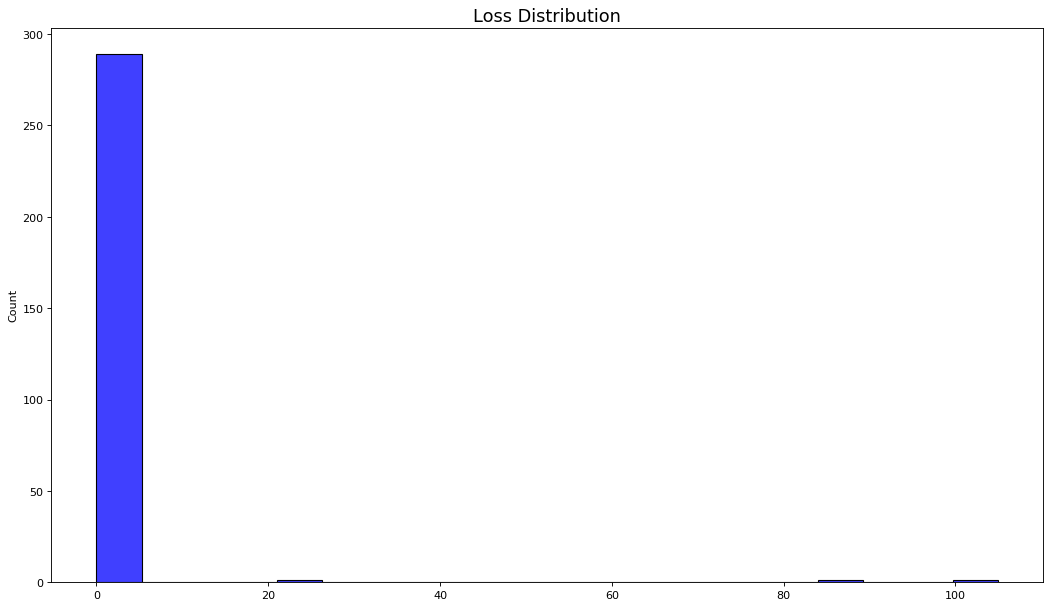

In [20]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

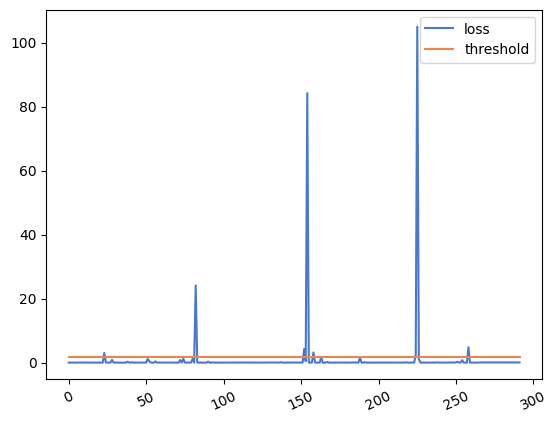

In [21]:

THRESHOLD =1.7

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss for loss in losses]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
#plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [22]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

/Users/ss049a/gitWorkspace/ImprovisedGAN/src/utils/util.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_score_df.loc[i, 'anomaly'] = 1


In [23]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 23
True Negative	 255
False Positive	 6
False Negative	 8
Accuracy	 0.952054794520548
Precision	 0.7931034482758621
Recall	 0.7419354838709677
f-measure	 0.7666666666666667
cohen_kappa_score	 0.7399821905609973
auc	 0.8594734890619207
roc_auc	 0.8594734890619207
